In [72]:
import pandas as pd

DATA = pd.read_csv('Bakery sales.csv')
DATA.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


In [74]:
DATA_CLEANED = DATA.loc[DATA['article'] != '.'].copy()
DATA_CLEANED['ticket_number'] = pd.to_numeric(DATA_CLEANED['ticket_number'], downcast='integer')
DATA_CLEANED['at'] = pd.to_datetime(DATA_CLEANED['date'] + ' ' + DATA_CLEANED['time'])
DATA_CLEANED['month'] = DATA_CLEANED['at'].dt.month
DATA_CLEANED['day'] = DATA_CLEANED['at'].dt.weekday
DATA_CLEANED['minute'] = (DATA_CLEANED['at'].dt.hour - 7) * 60 + DATA_CLEANED['at'].dt.minute
DATA_CLEANED = DATA_CLEANED.drop(columns=['Unnamed: 0', 'Quantity', 'unit_price', 'date', 'time', 'at'])
DATA_CLEANED

,ticket_number,article,month,day,minute
0,150040,BAGUETTE,1,5,98
1,150040,PAIN AU CHOCOLAT,1,5,98
2,150041,PAIN AU CHOCOLAT,1,5,134
3,150041,PAIN,1,5,134
4,150042,TRADITIONAL BAGUETTE,1,5,145
...,...,...,...,...,...
234000,288911,COUPE,9,4,712
234001,288911,BOULE 200G,9,4,712
234002,288911,COUPE,9,4,712
234003,288912,TRADITIONAL BAGUETTE,9,4,715


In [75]:
ITEMS = DATA_CLEANED['article'].unique()
ITEMS

array(['BAGUETTE', 'PAIN AU CHOCOLAT', 'PAIN', 'TRADITIONAL BAGUETTE',
       'CROISSANT', 'BANETTE', 'BANETTINE', 'SPECIAL BREAD', 'COUPE',
       'SAND JB EMMENTAL', 'KOUIGN AMANN', 'BOULE 200G', 'BOULE 400G',
       'GAL FRANGIPANE 6P', 'CAMPAGNE', 'MOISSON', 'CAFE OU EAU',
       'BRIOCHE', 'CEREAL BAGUETTE', 'SEIGLE', 'COMPLET',
       'DIVERS PATISSERIE', 'GAL FRANGIPANE 4P', 'COOKIE', 'FICELLE',
       'PAIN AUX RAISINS', 'GAL POMME 6P', 'GAL POMME 4P', 'FINANCIER X5',
       'VIK BREAD', 'DIVERS VIENNOISERIE', 'GACHE', 'SANDWICH COMPLET',
       'PAIN BANETTE', 'GRAND FAR BRETON', 'QUIM BREAD',
       'SPECIAL BREAD KG', 'GD KOUIGN AMANN', 'BOULE POLKA',
       'DEMI BAGUETTE', 'CHAUSSON AUX POMMES', 'BAGUETTE GRAINE',
       'DIVERS CONFISERIE', 'SUCETTE', 'DIVERS BOULANGERIE',
       'BOISSON 33CL', 'PATES', 'FORMULE SANDWICH', 'DIVERS SANDWICHS',
       'CROISSANT AMANDES', 'PAIN CHOCO AMANDES', 'SACHET VIENNOISERIE',
       'NANTAIS', 'CHOCOLAT', 'PAIN S/SEL', 'FONDANT CHOC

In [4]:
DATA_CLEANED=DATA.loc[DATA['article']!='.']

In [76]:
TRANSACTIONS = DATA_CLEANED.groupby('ticket_number').agg({'article': list, 'month': 'first', 'day': 'first', 'minute': 'first'})
TRANSACTIONS.head()

,article,month,day,minute
ticket_number,,,,
150040,"[BAGUETTE, PAIN AU CHOCOLAT]",1,5,98
150041,"[PAIN AU CHOCOLAT, PAIN]",1,5,134
150042,[TRADITIONAL BAGUETTE],1,5,145
150043,"[BAGUETTE, CROISSANT]",1,5,145
150044,[BANETTE],1,5,147


In [77]:
def items_to_numeric(items: list[str]) -> list[int]:
    return [1 if item in items else 0 for item in ITEMS]

TRANSACTIONS_WITH_NUMERIC_ITEMS = TRANSACTIONS.copy()
TRANSACTIONS_WITH_NUMERIC_ITEMS['article'] = TRANSACTIONS_WITH_NUMERIC_ITEMS['article'].apply(items_to_numeric)

TRANSACTIONS_WITH_NUMERIC_ITEMS


,article,month,day,minute
ticket_number,,,,
150040,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,98
150041,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,134
150042,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,145
150043,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,145
150044,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5,147
...,...,...,...,...
288908,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,4,694
288910,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,4,699
288911,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, ...",9,4,712


In [130]:
import math

def items_distance(a, b):
    return sum(abs(a[i] - b[i]) for i in range(len(a)))

def mean_of_items(series: pd.Series):
    mean = [0] * len(ITEMS)
    for items in series:
        for i, item in enumerate(items):
            mean[i] += item
    for i in range(len(ITEMS)):
        mean[i] /= len(series)
    return mean

def month_distance(a: int, b: int) -> float:
    return min(abs(a - b), 12 - abs(a - b))

def day_distance(a: int, b: int, cluster_size: int, count_of_transactions_with_day: int) -> float:
    if a == b:
        return 1 - count_of_transactions_with_day / cluster_size
    return 1

def distance(a, b, cluster_size: int, count_of_transactions_with_day: int, weight_month: float, weight_minute: float, weight_day: float, weight_article: float) -> float:
    return month_distance(a.month, b.month) * weight_month + \
        abs(b.minute - a.minute) * weight_minute + \
        day_distance(a.day, b.day, cluster_size, count_of_transactions_with_day) * weight_day + \
        items_distance(a.article, b.article) * weight_article

def clusterize(transactions: pd.DataFrame, k: int, weight_month: float, weight_minute: float, weight_day: float, weight_article: float) -> dict:
    centers = transactions.sample(k).reset_index().drop(columns=['ticket_number']).copy().astype({
        'month': 'float',
        'day': 'float',
        'minute': 'float',
    })

    # Assign transactions uniformly to clusters.
    clusters = []
    count_of_transactions_per_cluster_per_day = [[0] * 7 for _ in range(k)]
    transactions_per_cluster = (len(transactions) + k - 1) // k
    for i, transaction in enumerate(transactions.itertuples()):
        cluster = i // transactions_per_cluster
        clusters.append(cluster)
        count_of_transactions_per_cluster_per_day[cluster][transaction.day] += 1

    last_sum_of_distances_to_center = None
    sum_of_distances_to_center = math.inf
    
    while last_sum_of_distances_to_center is None or sum_of_distances_to_center < last_sum_of_distances_to_center:
        last_sum_of_distances_to_center = sum_of_distances_to_center
        sum_of_distances_to_center = 0

        for i, transaction in enumerate(transactions.itertuples()):
            min_d = None
            best_center = None

            for j, center in enumerate(centers.itertuples()):
                d = distance(transaction, center, len(transactions), count_of_transactions_per_cluster_per_day[j][transaction.day], weight_month, weight_minute, weight_day, weight_article)
                if min_d is None or d < min_d:
                    min_d = d
                    best_center = j
            
            sum_of_distances_to_center += min_d
            clusters[i] = best_center

        # Add a cluster column to the transactions DataFrame.
        transactions_with_clusters = transactions.copy()
        transactions_with_clusters['cluster'] = clusters

        for i in range(k):
            transactions_in_cluster = transactions_with_clusters.loc[transactions_with_clusters['cluster'] == i]
            index = centers.index[i]
            centers.loc[index, 'month'] = transactions_in_cluster['month'].mean()
            centers.loc[index, 'day'] = transactions_in_cluster['day'].mean()
            centers.loc[index, 'minute'] = transactions_in_cluster['minute'].mean()
            centers.loc[[index], 'article'] = pd.Series([mean_of_items(transactions_in_cluster['article'])], index=[index])
        
        # Update count_of_transactions_per_cluster_per_day
        count_of_transactions_per_cluster_per_day = [[0] * 7 for _ in range(k)]
        for transaction in transactions_with_clusters.itertuples():
            count_of_transactions_per_cluster_per_day[transaction.cluster][transaction.day] += 1
        
    return centers, clusters

SAMPLES = TRANSACTIONS_WITH_NUMERIC_ITEMS.sample(1000)
CENTERS, CLUSTERS = clusterize(SAMPLES, 8, 100, 2, 100, 2000)

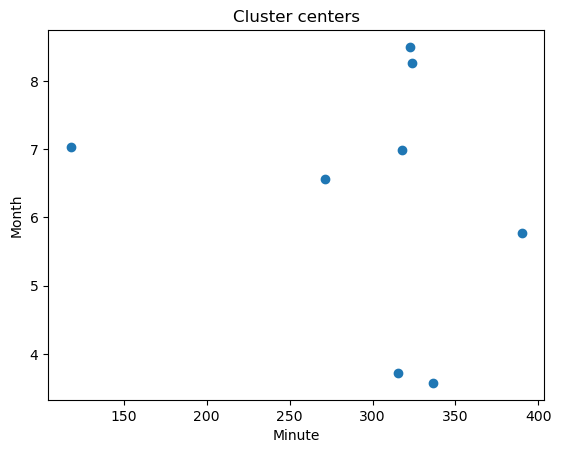

In [131]:
from matplotlib import pyplot as plt

plt.scatter(CENTERS['minute'], CENTERS['month'])
plt.xlabel('Minute')
plt.ylabel('Month')
plt.title('Cluster centers')
plt.show()

<Axes: xlabel='month', ylabel='minute'>

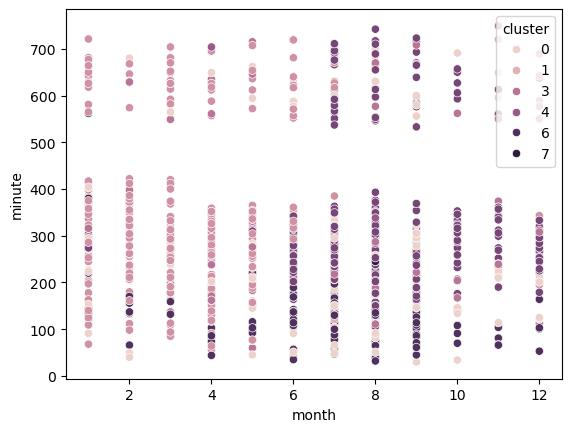

In [132]:
import seaborn as sns

TRANSACTIONS_WITH_CLUSTERS = SAMPLES.copy()
TRANSACTIONS_WITH_CLUSTERS['cluster'] = CLUSTERS

sns.scatterplot(data=TRANSACTIONS_WITH_CLUSTERS, x='month', y='minute', hue='cluster')

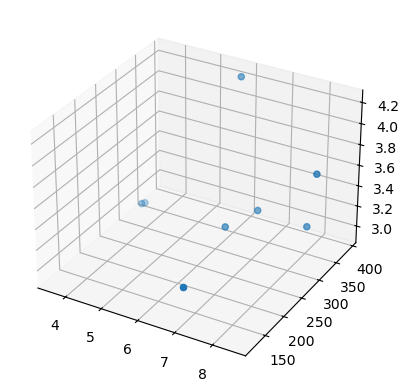

In [133]:
plot = plt.axes(projection='3d')
plot.scatter3D(CENTERS['month'], CENTERS['minute'], CENTERS['day'])

In [134]:
import itertools
from typing import Iterable

MINSUP = 0.3

def remove_infrequent_patterns(transactions: Iterable[frozenset[str]], patterns: list[frozenset[str]], threshold: int):
    counts = [0] * len(patterns)

    for transaction in transactions:
        for i, pattern in enumerate(patterns):
            if pattern.issubset(transaction):
                counts[i] += 1

    i = 0
    while i < len(patterns):
        if counts[i] < threshold:
            del patterns[i]
            del counts[i]
        else:
            i += 1

def get_candidates(F_k: list[frozenset[str]], k: int) -> set[frozenset[str]]:
    C_k_plus_1 = set()

    for i, p in enumerate(F_k):
        for q in F_k[i + 1:]:
            candidate = p.union(q)
            if len(candidate) != k + 1:
                continue
            all_subsets_of_candidate_are_frequent = True
            for subset in itertools.combinations(candidate, k):
                if set(subset) not in F_k:
                    all_subsets_of_candidate_are_frequent = False
                    break
            if not all_subsets_of_candidate_are_frequent:
                continue
            C_k_plus_1.add(candidate)

    return C_k_plus_1

def apriori(transactions: Iterable[frozenset[str]], items: frozenset[str], minsup: float) -> list[frozenset[str]]:
    threshold = minsup * len(transactions)

    # Start with singletons.
    F_1 = [frozenset([item]) for item in items]
    remove_infrequent_patterns(transactions, F_1, threshold)

    F = [F_1]

    for k in range(1, len(items)):
        C_k_plus_1 = get_candidates(F[-1], k)

        F_k_plus_1 = list(C_k_plus_1)
        remove_infrequent_patterns(transactions, F_k_plus_1, threshold)

        if not F_k_plus_1:
            break

        F.append(F_k_plus_1)

    return [pattern for F_k in F for pattern in F_k]

MONTHS = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
DAYS = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i in range(len(CENTERS)):
    transactions_in_cluster = TRANSACTIONS_WITH_CLUSTERS.loc[TRANSACTIONS_WITH_CLUSTERS['cluster'] == i].copy()
    transactions_in_cluster['article'] = transactions_in_cluster['article'].apply(lambda x: frozenset(ITEMS[j] for j in range(len(x)) if x[j] == 1))
    items = frozenset(itertools.chain(*transactions_in_cluster['article']))
    frequent_patterns = apriori(transactions_in_cluster['article'], items, MINSUP)
    frequent_patterns.sort()

    month = MONTHS[math.floor(CENTERS['month'][i])]
    minute = math.floor(CENTERS['minute'][i])
    day = DAYS[math.floor(CENTERS['day'][i])]

    hour = str(7 + math.floor(CENTERS['minute'][i] // 60))
    minute = str(math.floor(CENTERS['minute'][i]) % 60).zfill(2)

    print(f'Patterns in cluster {i} ({day} {month} at {hour}:{minute}):')
    for pattern in frequent_patterns:
        print(', '.join(pattern))
    print()

Patterns in cluster 0 (Thursday July at 11:31):
BANETTE
CROISSANT

Patterns in cluster 1 (Thursday September at 12:22):
TRADITIONAL BAGUETTE
SPECIAL BREAD
FINANCIER X5
COOKIE
SPECIAL BREAD, FINANCIER X5
TRADITIONAL BAGUETTE, COOKIE
COOKIE, SPECIAL BREAD
COOKIE, FINANCIER X5

Patterns in cluster 2 (Wednesday April at 12:36):
TRADITIONAL BAGUETTE

Patterns in cluster 3 (Thursday July at 12:17):
COUPE

Patterns in cluster 4 (Friday June at 13:29):
COUPE
VIK BREAD
BANETTE
COUPE, BANETTE
COUPE, VIK BREAD

Patterns in cluster 5 (Thursday September at 12:23):
TRADITIONAL BAGUETTE

Patterns in cluster 6 (Thursday August at 8:57):
TRADITIONAL BAGUETTE
PAIN AU CHOCOLAT

Patterns in cluster 7 (Thursday April at 12:15):
BANETTE
COOKIE
COOKIE, BANETTE

